# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)

**More readings from YL**
- https://huggingface.co/blog/annotated-diffusion


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

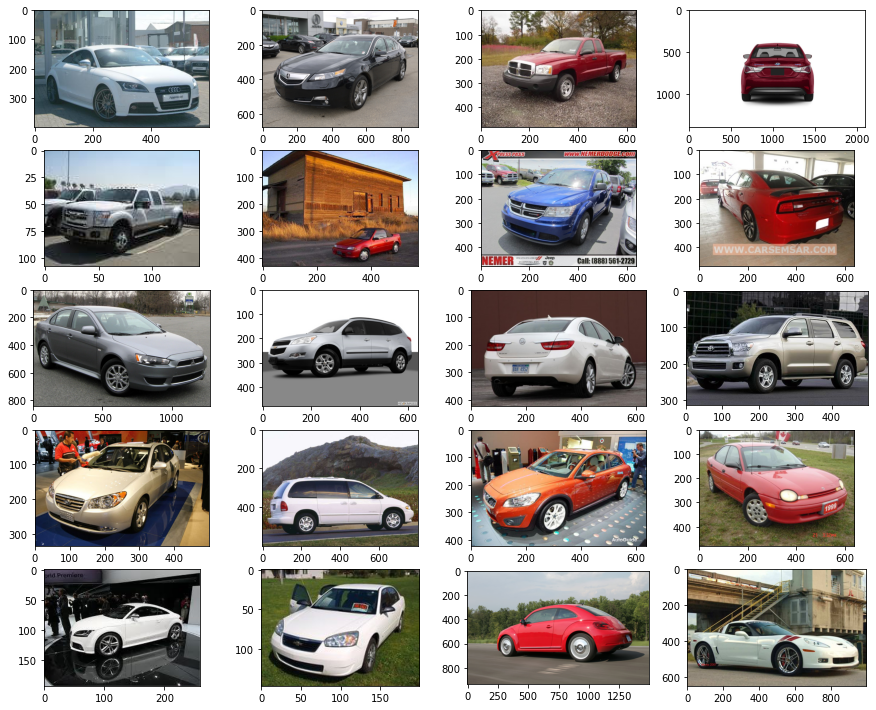

In [48]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

# follow this: https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616
data = torchvision.datasets.StanfordCars(root="/home/youliang/Downloads", download=False)

show_images(dataset)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [40]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [57]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 256

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root="/home/youliang/Downloads", download=False,
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root="/home/youliang/Downloads", download=False,
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=5)

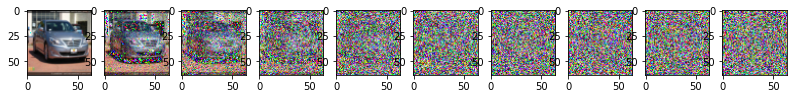

In [50]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [51]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [52]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [53]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

Epoch 0 | step 000 Loss: 0.12712031602859497 


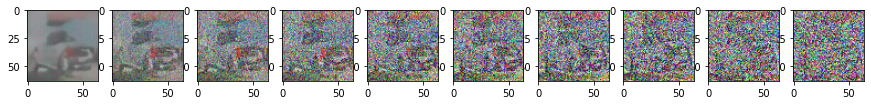

Epoch 1 | step 000 Loss: 0.13476994633674622 
Epoch 2 | step 000 Loss: 0.13384026288986206 
Epoch 3 | step 000 Loss: 0.13117238879203796 
Epoch 4 | step 000 Loss: 0.12566791474819183 
Epoch 5 | step 000 Loss: 0.12792836129665375 


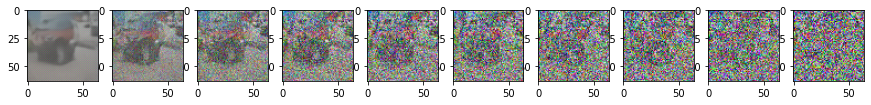

Epoch 6 | step 000 Loss: 0.13212019205093384 
Epoch 7 | step 000 Loss: 0.13106292486190796 
Epoch 8 | step 000 Loss: 0.13835100829601288 
Epoch 9 | step 000 Loss: 0.12492718547582626 
Epoch 10 | step 000 Loss: 0.1192849725484848 


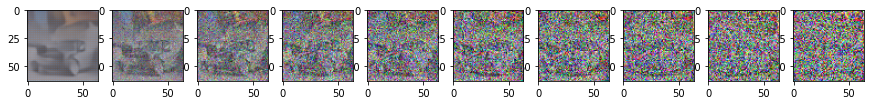

Epoch 11 | step 000 Loss: 0.1329624205827713 
Epoch 12 | step 000 Loss: 0.129799485206604 
Epoch 13 | step 000 Loss: 0.1274014562368393 
Epoch 14 | step 000 Loss: 0.1239284873008728 
Epoch 15 | step 000 Loss: 0.1273801624774933 


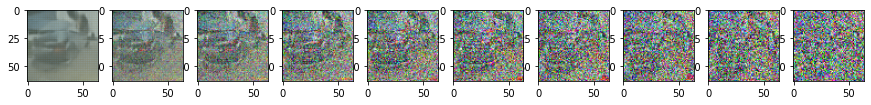

Epoch 16 | step 000 Loss: 0.13116228580474854 
Epoch 17 | step 000 Loss: 0.12785910069942474 
Epoch 18 | step 000 Loss: 0.1329919397830963 
Epoch 19 | step 000 Loss: 0.1249556839466095 
Epoch 20 | step 000 Loss: 0.13120722770690918 


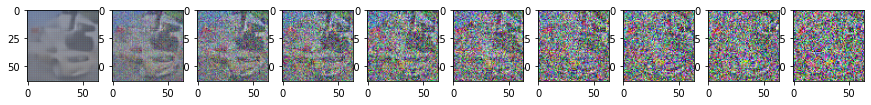

Epoch 21 | step 000 Loss: 0.14324258267879486 
Epoch 22 | step 000 Loss: 0.12270669639110565 
Epoch 23 | step 000 Loss: 0.12444323301315308 
Epoch 24 | step 000 Loss: 0.1257198452949524 
Epoch 25 | step 000 Loss: 0.1339382827281952 


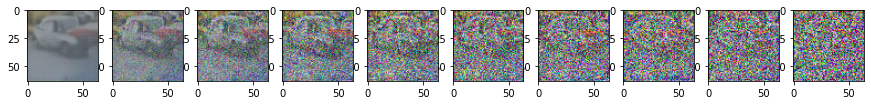

Epoch 26 | step 000 Loss: 0.14178740978240967 
Epoch 27 | step 000 Loss: 0.12288908660411835 
Epoch 28 | step 000 Loss: 0.13089215755462646 
Epoch 29 | step 000 Loss: 0.1313406229019165 
Epoch 30 | step 000 Loss: 0.1251099407672882 


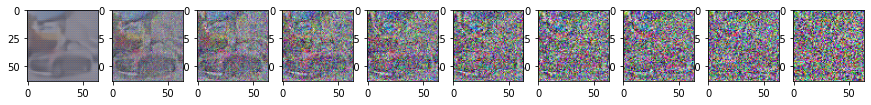

Epoch 31 | step 000 Loss: 0.1197175607085228 
Epoch 32 | step 000 Loss: 0.1324082612991333 
Epoch 33 | step 000 Loss: 0.13696052134037018 
Epoch 34 | step 000 Loss: 0.13563275337219238 
Epoch 35 | step 000 Loss: 0.13988934457302094 


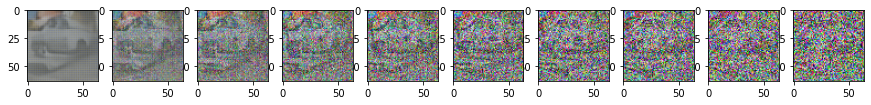

Epoch 36 | step 000 Loss: 0.13313263654708862 
Epoch 37 | step 000 Loss: 0.12752780318260193 
Epoch 38 | step 000 Loss: 0.12634800374507904 
Epoch 39 | step 000 Loss: 0.13343285024166107 
Epoch 40 | step 000 Loss: 0.1276041716337204 


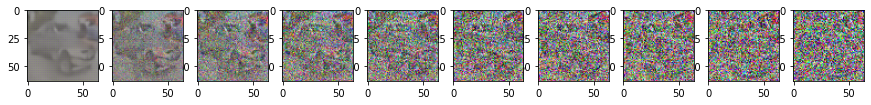

Epoch 41 | step 000 Loss: 0.1230025440454483 
Epoch 42 | step 000 Loss: 0.12802335619926453 
Epoch 43 | step 000 Loss: 0.13598769903182983 
Epoch 44 | step 000 Loss: 0.13584323227405548 
Epoch 45 | step 000 Loss: 0.13088031113147736 


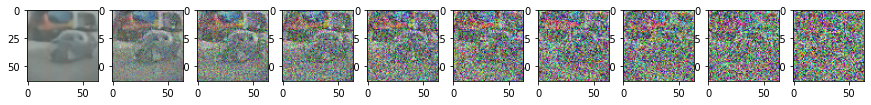

Epoch 46 | step 000 Loss: 0.13003042340278625 
Epoch 47 | step 000 Loss: 0.1292319893836975 
Epoch 48 | step 000 Loss: 0.1309305727481842 
Epoch 49 | step 000 Loss: 0.11806190013885498 
Epoch 50 | step 000 Loss: 0.13242924213409424 


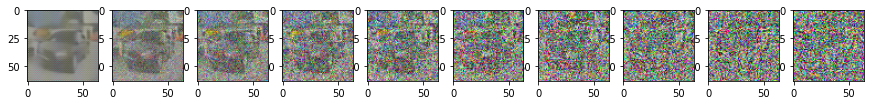

Epoch 51 | step 000 Loss: 0.1320536732673645 
Epoch 52 | step 000 Loss: 0.13619694113731384 
Epoch 53 | step 000 Loss: 0.12669897079467773 
Epoch 54 | step 000 Loss: 0.13286112248897552 
Epoch 55 | step 000 Loss: 0.12317794561386108 


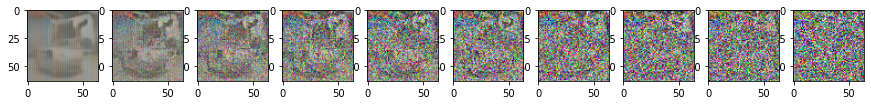

Epoch 56 | step 000 Loss: 0.12139838933944702 
Epoch 57 | step 000 Loss: 0.14031553268432617 
Epoch 58 | step 000 Loss: 0.1321895718574524 
Epoch 59 | step 000 Loss: 0.13249491155147552 
Epoch 60 | step 000 Loss: 0.1314217746257782 


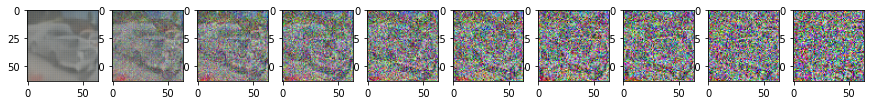

Epoch 61 | step 000 Loss: 0.13241755962371826 
Epoch 62 | step 000 Loss: 0.11714144051074982 
Epoch 63 | step 000 Loss: 0.1296679526567459 
Epoch 64 | step 000 Loss: 0.1268756091594696 
Epoch 65 | step 000 Loss: 0.134074866771698 


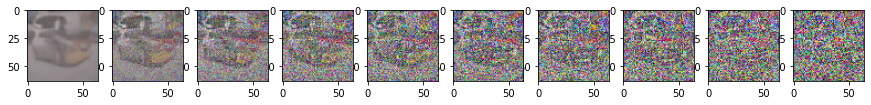

Epoch 66 | step 000 Loss: 0.12845191359519958 
Epoch 67 | step 000 Loss: 0.13613328337669373 
Epoch 68 | step 000 Loss: 0.1262011080980301 
Epoch 69 | step 000 Loss: 0.12158157676458359 
Epoch 70 | step 000 Loss: 0.13531571626663208 


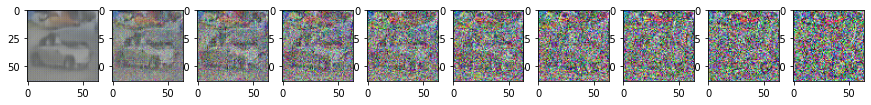

Epoch 71 | step 000 Loss: 0.12766313552856445 
Epoch 72 | step 000 Loss: 0.1261712908744812 
Epoch 73 | step 000 Loss: 0.13252925872802734 
Epoch 74 | step 000 Loss: 0.13776613771915436 
Epoch 75 | step 000 Loss: 0.12303586304187775 


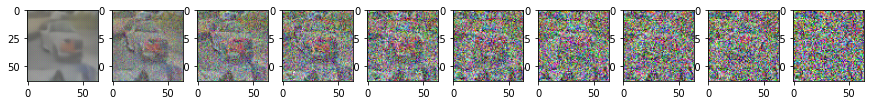

Epoch 76 | step 000 Loss: 0.12857139110565186 
Epoch 77 | step 000 Loss: 0.12500643730163574 
Epoch 78 | step 000 Loss: 0.12036459147930145 
Epoch 79 | step 000 Loss: 0.12277895212173462 
Epoch 80 | step 000 Loss: 0.12259852886199951 


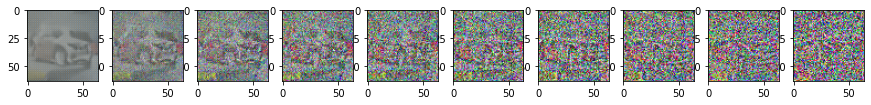

Epoch 81 | step 000 Loss: 0.11976992338895798 
Epoch 82 | step 000 Loss: 0.1248653456568718 
Epoch 83 | step 000 Loss: 0.1310632824897766 
Epoch 84 | step 000 Loss: 0.12987516820430756 
Epoch 85 | step 000 Loss: 0.12380427122116089 


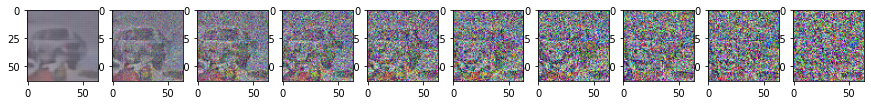

Epoch 86 | step 000 Loss: 0.11977296322584152 
Epoch 87 | step 000 Loss: 0.1219540685415268 
Epoch 88 | step 000 Loss: 0.1274644136428833 
Epoch 89 | step 000 Loss: 0.1294335424900055 
Epoch 90 | step 000 Loss: 0.13039952516555786 


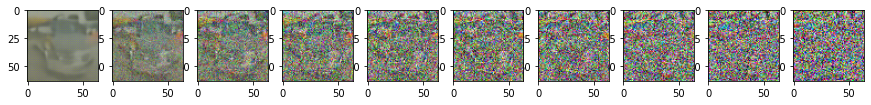

Epoch 91 | step 000 Loss: 0.12514913082122803 
Epoch 92 | step 000 Loss: 0.13183848559856415 
Epoch 93 | step 000 Loss: 0.12261341512203217 
Epoch 94 | step 000 Loss: 0.11995866149663925 
Epoch 95 | step 000 Loss: 0.13761961460113525 


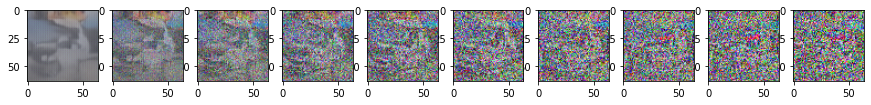

Epoch 96 | step 000 Loss: 0.12034116685390472 
Epoch 97 | step 000 Loss: 0.12777873873710632 
Epoch 98 | step 000 Loss: 0.12435387074947357 
Epoch 99 | step 000 Loss: 0.12984208762645721 


In [61]:
from torch.optim import Adam, AdamW

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.0002)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        if epoch % 5 == 0:
            sample_plot_image()